In [ ]:
#IMPORTS

In [10]:
!pip install numpy

Defaulting to user installation because normal site-packages is not writeable


In [11]:
import numpy as np
from mosplot.plot import load_lookup_table, Mosfet, Expression

In [12]:
lookup_table = load_lookup_table("/home/just/Desktop/teste3/gmid-main/tests/lookup_table_generator/tsm65nm/tsmc65nm_V4.npz")

In [13]:
print(lookup_table.keys())

dict_keys(['nch_mac', 'pch_mac', 'description', 'simulator', 'parameter_names', 'device_parameters'])


In [14]:
#Making Simple Plots

In [15]:
nmos = Mosfet(lookup_table=lookup_table, mos="nch_mac", vbs=0.0, vds=0.6, vgs=(0.2, 1.2))
pmos = Mosfet(lookup_table=lookup_table, mos="pch_mac", vbs=0.0, vds=-0.6, vgs=(-1.2, -0.2))

In [17]:
print(nmos.length)

[6.00e-08 6.50e-08 7.00e-08 7.50e-08 8.00e-08 8.50e-08 9.00e-08 9.50e-08
 1.00e-07 1.05e-07 1.10e-07 1.15e-07 1.20e-07 1.80e-07 2.40e-07 3.00e-07
 3.60e-07 4.20e-07 4.80e-07 5.40e-07 6.00e-07 6.60e-07 7.20e-07 7.80e-07
 8.40e-07 9.00e-07 9.60e-07 1.02e-06 1.08e-06 1.14e-06]


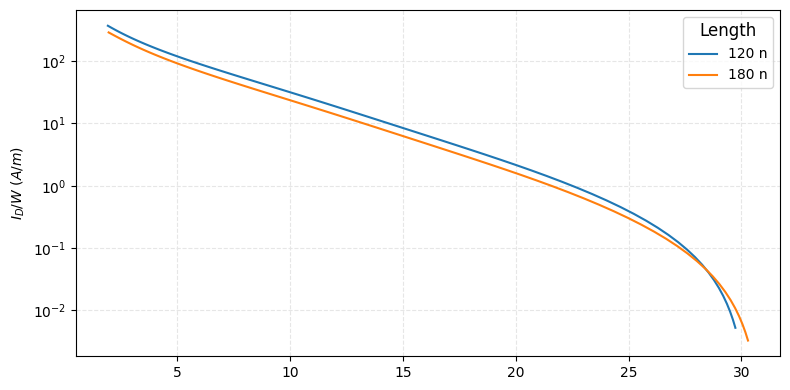

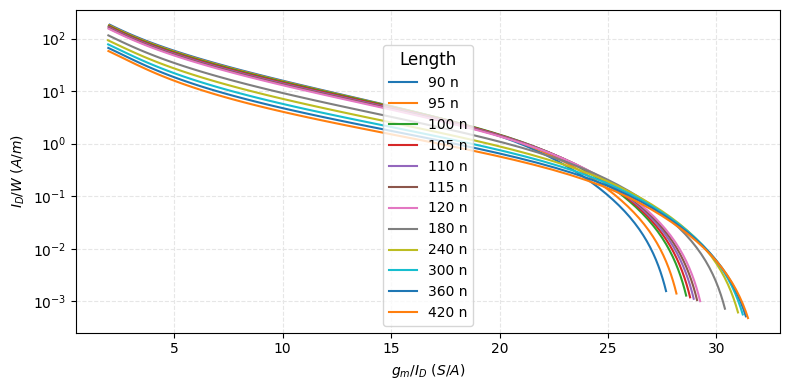

In [18]:
nmos.plot_by_expression(
    y_expression = nmos.current_density_expression,
    x_expression = Expression(
        variables=["gm", "id"],#Rever isto 
        function=lambda x, y: x / (y),
        ),
    filtered_values = nmos.length[12:14],
    y_scale="log",
)

pmos.plot_by_expression(
    y_expression = pmos.current_density_expression,
    x_expression = pmos.gmid_expression,
    filtered_values = nmos.length[6:18],
    y_scale="log",
)

In [19]:
print(nmos.extracted_table.keys())


dict_keys(['weff', 'id', 'vth', 'gm', 'gmbs', 'gds', 'cgg', 'cgs', 'cgb', 'cgd', 'cdd', 'length', 'vbs', 'vgs', 'vds'])


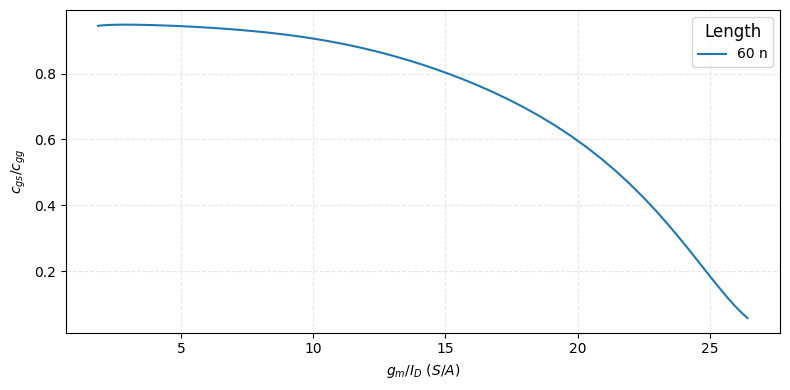

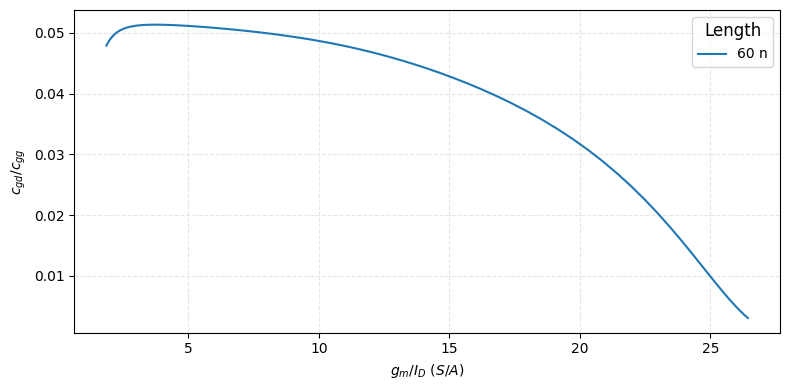

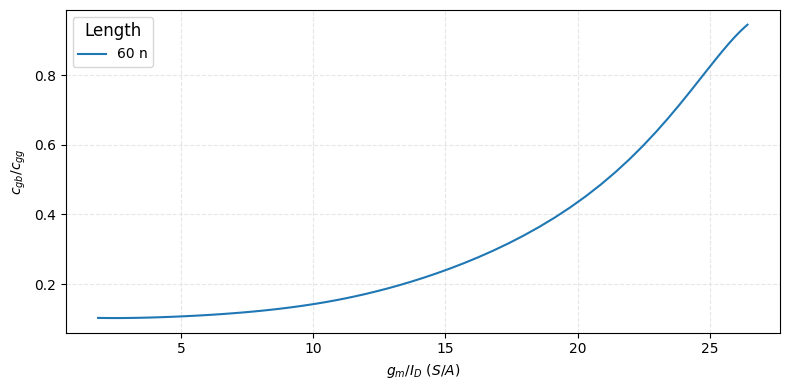

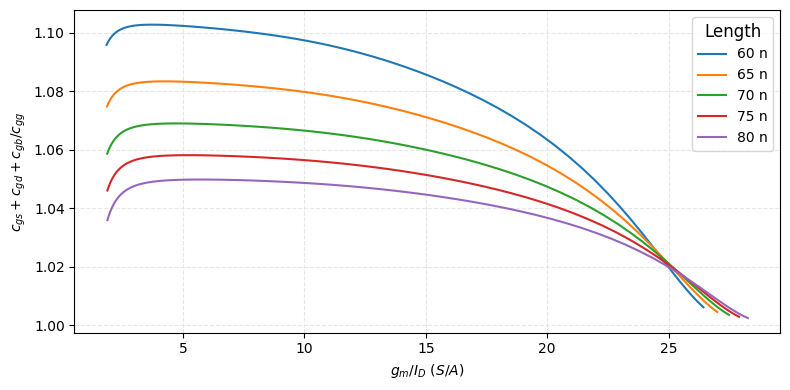

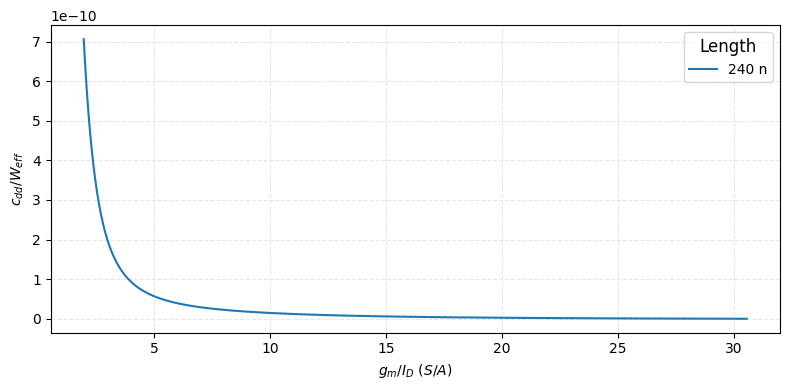

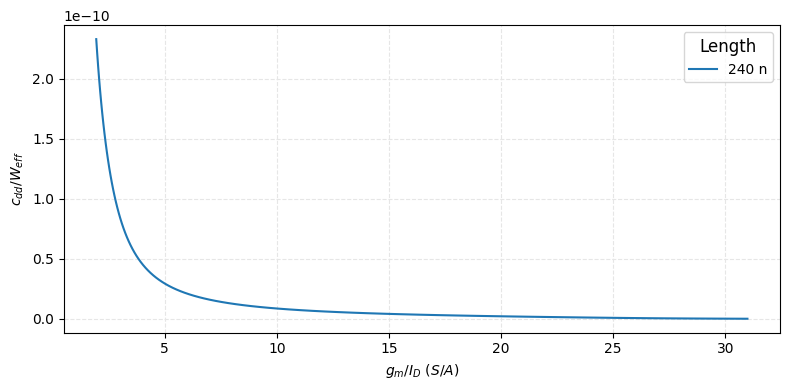

In [20]:
nmos.plot_by_expression(
    x_expression = nmos.gmid_expression,
    y_expression = Expression(
        variables=["cgs", "cgd", "cgb", "cgg"],
        function=lambda x, y, z, w: (-x) / (w),
        label="$c_{gs} / c_{gg}$",
        ),
    filtered_values = nmos.length[0],
)
nmos.plot_by_expression(
    x_expression = nmos.gmid_expression,
    y_expression = Expression(
        variables=["cgs", "cgd", "cgb", "cgg"],
        function=lambda x, y, z, w: (y) / (w),
        label="$c_{gd} / c_{gg}$",
        ),
    filtered_values = nmos.length[0],
)
nmos.plot_by_expression(
    x_expression = nmos.gmid_expression,
    y_expression = Expression(
        variables=["cgs", "cgd", "cgb", "cgg"],
        function=lambda x, y, z, w: (-z) / (w),
        label="$c_{gb} / c_{gg}$",
        ),
    filtered_values = nmos.length[0],
)

nmos.plot_by_expression(
    x_expression = nmos.gmid_expression,
    y_expression = Expression(
        variables=["cgs", "cgd", "cgb", "cgg"],
        function=lambda x, y, z, w: (-x-z+y) / (w),
        label="$c_{gs}+c_{gd}+c_{gb} / c_{gg}$",
        ),
    filtered_values = nmos.length[:5],
)
nmos.plot_by_expression(
    x_expression = nmos.gmid_expression,
    y_expression = Expression(
        variables=["cdd","weff"],
        function=lambda x, y: x/y,
        label="$c_{dd}/ W_{eff}$",
        ),
    filtered_values = nmos.length[14],
)
pmos.plot_by_expression(
    x_expression = pmos.gmid_expression,
    y_expression = Expression(
        variables=["cdd","weff"],
        function=lambda x, y: x/y,
        label="$c_{dd}/ W_{eff}$",
        ),
    filtered_values = pmos.length[14],
)

In [21]:
import numpy as np
from scipy import constants
from dataclasses import dataclass
from typing import Optional
#
# Constants
k = constants.Boltzmann
TEMP = 300  # Kelvin

# --------------------------------------------
# Data Structures
# --------------------------------------------
@dataclass
class Specs:
    """Design specifications"""
    ts: float         # Settling time (s)
    fu1: float        # Unity gain freq (Hz)
    fp2: float        # Non-dominant pole (Hz)
    vod_noise: float  # Input-referred noise (V)
    G: float          # Closed-loop gain
    FO: float         # Fan-out
    L0: float         # Open-loop gain spec

@dataclass
class DesignParams:
    """Assumed parameters"""
    beta: float = None         # Will be computed as 0.75*beta_max
    beta_max: float = None     # Derived from G when not provided
    slew_frac: float = None     # Slew fraction of ts
    rself1: float = None        # Self-loading factor stage 1
    rself2: float = None        # Self-loading factor stage 2
    cgs2_cc: float = None       # Cgs2/CC ratio
    cltot_cc: float = None      # CLtot/CC initial assumption
    gm3_gm1: float = None       # M3/M1 gm ratio
    gm4_gm2: float = None       # M4/M2 gm ratio
    gam1: float = None          # Noise coeff M1
    gam2: float = None          # Noise coeff M2
    gam3: float = None          # Noise coeff M3
    gam4: float = None          # Noise coeff M4

@dataclass
class Transistor:
    """Transistor design parameters with PDK properties"""
    L: float                    # Channel length [m]
    # Design variables
    gm: Optional[float] = None  # Transconductance [S]
    id: Optional[float] = None  # Drain current [A]
    gm_id: Optional[float] = None  # gm/ID ratio [S/A]
    w: Optional[float] = None   # Width [m]
    ft: Optional[float] = None 
    # Capacitances
    cgg: Optional[float] = None  # Total gate cap [F]
    cgs: Optional[float] = None  # Gate-source cap [F]
    cgd: Optional[float] = None  # Gate-drain cap [F]
    cdd: Optional[float] = None  # Total drain cap [F]
    

@dataclass
class Circuit:
    """Circuit components"""
    cc: Optional[float] = None
    cltot: Optional[float] = None
    cf: Optional[float] = None
    cs: Optional[float] = None
    cl: Optional[float] = None
    c1: Optional[float] = None
    rz: Optional[float] = None
    cn: Optional[float] = None
    cc_add: Optional[float] = None


In [22]:
def calculate_capacitances(specs: Specs, params: DesignParams, m2: Transistor) -> Circuit:
    circuit = Circuit()
    kT = k * TEMP
    print("k=",k)
    
    # Auto-compute beta if not provided
    if params.beta_max is None:
        params.beta_max = 1 / (1 + specs.G)
    if params.beta is None:
        params.beta = 0.75 * params.beta_max
    
    # Noise-derived CC calculation 
    numerator = (2/params.beta * kT * params.gam1 * (1 + params.gam3/params.gam1 * params.gm3_gm1) + 
                1/params.cltot_cc * kT * (1 + params.gam2 * (1 + params.gam4/params.gam2 * params.gm4_gm2)))
    #numerator=(2*kT)*(((1/params.beta)*params.gam1*(1+ (params.gam3/params.gam1)*params.gm3_gm1))+(1+params.gam2*(1+(params.gam4/params.gam2)*params.gm4_gm2)))
    circuit.cc = numerator / (specs.vod_noise ** 2)
    # Downstream capacitances
    circuit.cltot = circuit.cc * params.cltot_cc #cltot=cc
    #circuit.cf = circuit.cltot / (1 + params.rself2) / (1 - params.beta + specs.FO * specs.G)
    circuit.cf = circuit.cltot / ((1 + params.rself2)*(1 - params.beta + specs.FO * specs.G))
    circuit.cs = circuit.cf * specs.G
    circuit.cl = circuit.cs * specs.FO

    m2.cgs = circuit.cc * params.cgs2_cc  # cgs2_cc=1/3
    circuit.c1 = m2.cgs * (1 + params.rself1)  
    
    return circuit

In [23]:
def calculate_m1_parameters(m1: Transistor, specs: Specs, params: DesignParams, circuit: Circuit) -> Transistor:
    """Calculate M1 parameters 
    
    Args:
        m1: Pre-initialized transistor with L and PDK parameters
        specs: Design specifications
        params: Design parameters
        circuit: Calculated circuit components
        
    Returns:
        Configured M1 transistor with all calculated parameters
    """
    # Calculate gmR 
    gmR = np.sqrt(specs.L0) / params.beta #possivelmente os valores de teste sao demasiado elevados (rever)
    print("gmR=",gmR)
    # Transconductance calculation 
    m1.gm = (2 * np.pi * specs.fu1 * circuit.cc / params.beta * 
            (1 + (1 + circuit.c1/circuit.cc)/gmR + 
             (1 + circuit.cltot/circuit.cc)/gmR))
    
    # Gate capacitance 
    m1.cgg = circuit.cf * ((1/params.beta) - 1 - specs.G)
    
    # Transition frequency
    m1.ft = m1.gm / m1.cgg / (2 * np.pi)
    #print("gm/cgg=",m1.ft*2*np.pi)
    
    # gm/ID lookup 
    m1.gm_id=pmos.interpolate(
        x_expression=pmos.length_expression,
        x_value=m1.L,
        y_expression = Expression(
        variables=["gm", "cgg"],
        function=lambda x, y: x / y,
        ),
        y_value=m1.gm/m1.cgg,
        z_expression=pmos.gmid_expression
    ).item() 

    # Drain current
    m1.id = m1.gm / m1.gm_id
    
    return m1

In [24]:
def calculate_m2_parameters(m2: Transistor, specs: Specs, params: DesignParams, circuit: Circuit) -> Transistor:
    """Calculate M2 parameters 
    
    Args:
        m2: Pre-initialized transistor with L and cgs parameters
        specs: Design specifications
        params: Design parameters
        circuit: Calculated circuit components
        
    Returns:
        Configured M2 transistor with all calculated parameters
    """
    # 1. Transconductance calculation 
    m2.gm = (2 * np.pi * specs.fp2 * 
            (1 + circuit.cltot/circuit.cc + circuit.cltot/circuit.c1) * 
            circuit.c1)
    
    # 2. Transition frequency 
    m2.ft = m2.gm / m2.cgs / (2 * np.pi)
    
    # 3. gm/ID lookup 
    m2.gm_id=nmos.interpolate(
        x_expression=nmos.length_expression,
        x_value=m2.L,
        y_expression = Expression(
        variables=["gm", "cgg"],#Rever isto 
        function=lambda x, y: x / (y),
        ),
        y_value=m2.gm/m2.cgs,
        z_expression=nmos.gmid_expression
    ).item()
    
    # 4. Drain current
    m2.id = m2.gm / m2.gm_id
    
    # 5. Nulling resistor (MATLAB: p.rz = 1./m2.gm)
    circuit.rz = 1 / m2.gm
    
    return m2

In [25]:
def calculate_transistor_widths(m1: Transistor, m2: Transistor, 
                               m3: Transistor, m4: Transistor,
                               params: DesignParams) -> None:
    """Calculate transistor widths 
    
    Args:
        m1: Input pair transistor
        m2: Second stage transistor
        m3: PMOS mirror for M1
        m4: PMOS mirror for M2
        params: Design parameters with gm ratios
    """
    # 1. Set current mirror gm/ID ratios 
    m3.gm_id = m1.gm_id * params.gm3_gm1  
    m4.gm_id = m2.gm_id * params.gm4_gm2  
    
    # 2. Calculate widths using current density (ID/W)
    m1.w = m1.id / pmos.interpolate(
        x_expression=pmos.length_expression,
        x_value=m1.L,
        y_expression=pmos.gmid_expression,
        y_value=m1.gm_id,
        z_expression=pmos.current_density_expression
    ).item() 

    m2.w = m2.id / nmos.interpolate(
        x_expression=nmos.length_expression,
        x_value=m2.L,
        y_expression=nmos.gmid_expression,
        y_value=m2.gm_id,
        z_expression=nmos.current_density_expression
    ).item() 

    # 3. Mirror devices inherit currents but have their own gm/ID
    m3.w = m1.id / nmos.interpolate(
        x_expression=nmos.length_expression,
        x_value=m3.L,
        y_expression=nmos.gmid_expression,
        y_value=m3.gm_id,
        z_expression=nmos.current_density_expression
    ).item() 

    m4.w = m2.id / pmos.interpolate(
        x_expression=pmos.length_expression,
        x_value=m4.L,
        y_expression=pmos.gmid_expression,
        y_value=m4.gm_id,
        z_expression=pmos.current_density_expression
    ).item() 

In [26]:
def calculate_compensation_caps(m1: Transistor, m2: Transistor, circuit: Circuit) -> None:
    """Calculate neutralization and compensation caps
    
    Args:
        m1: Input pair transistor
        m2: Second stage transistor
        circuit: Circuit components (updates cn and cc_add)
    """
    # 1. M1 gate-drain capacitance (neutralization cap)
    m1.cgd =m1.w*pmos.interpolate(
        x_expression=pmos.length_expression,
        x_value=m1.L,
        y_expression=pmos.gmid_expression,
        y_value=m1.gm_id,
        z_expression=Expression(
            variables=["cgd", "weff"],
            function=lambda x, y: x / (y),
        ),
    ).item()
    
    # 2. Set neutralization cap 
    circuit.cn = m1.cgd
    
    # 3. M2 gate-drain capacitance
    m2.cgd =m2.w*nmos.interpolate(
        x_expression=nmos.length_expression,
        x_value=m2.L,
        y_expression=nmos.gmid_expression,
        y_value=m2.gm_id,
        z_expression=Expression(
            variables=["cgd", "weff"],
            function=lambda x, y: x / (y),
        ),
    ).item() 
    
    # 4. Additional compensation cap 
    circuit.cc_add = circuit.cc - m2.cgd

In [35]:
def calculate_self_loading(m1: Transistor, m2: Transistor, 
                         m3: Transistor, m4: Transistor,
                         circuit: Circuit, params: DesignParams) -> None:
    """Calculate self-loading effects 
    
    Args:
        m1-m4: All transistors with calculated widths
        circuit: Circuit components (updates rself1/rself2)
        params: Design parameters (beta)
    """
    # 1. Drain capacitances
    m1.cdd = m1.w*pmos.interpolate(
        x_expression=pmos.length_expression,
        x_value=m1.L,
        y_expression=pmos.gmid_expression,
        y_value=m1.gm_id,
        z_expression=Expression(
            variables=["cdd", "weff"],
            function=lambda x, y: x / (y),
        ),
    ).item()
    
    m2.cdd = m2.w*nmos.interpolate(
        x_expression=nmos.length_expression,
        x_value=m2.L,
        y_expression=nmos.gmid_expression,
        y_value=m2.gm_id,
        z_expression=Expression(
            variables=["cdd", "weff"],
            function=lambda x, y: x / (y),
        ),
    ).item()
    
    m3.cdd = m3.w*nmos.interpolate(
        x_expression=nmos.length_expression,
        x_value=m3.L,
        y_expression=nmos.gmid_expression,
        y_value=m3.gm_id,
        z_expression=Expression(
            variables=["cdd", "weff"],
            function=lambda x, y: x / (y),
        ),
    ).item() 
    
    m4.cdd = m4.w*pmos.interpolate(
        x_expression=pmos.length_expression,
        x_value=m4.L,
        y_expression=pmos.gmid_expression,
        y_value=m4.gm_id,
        z_expression=Expression(
            variables=["cdd", "weff"],
            function=lambda x, y: x / (y),
        ),
    ).item() 
    
    # 2. Stage 1 self-loading 
    circuit.rself1 = (m1.cdd + m3.cdd) / m2.cgs
    
    # 3. Stage 2 self-loading 
    numerator = ((m2.cdd - m2.cgd) + m4.cdd)
    denominator = (circuit.cl + (1 - params.beta) * circuit.cf)
    circuit.rself2 = numerator / denominator

In [36]:
def test_opamp_design():
    """Complete test bench for opamp design calculations"""
    print("=== Opamp Design Test Bench ===\n")
    
    # 1. Define specifications 
    specs = Specs(
        ts=5e-9,         
        fu1=220e6,         
        fp2=6*220e6,         
        vod_noise=400e-6,   
        G=2,               
        FO=0.5,             
        L0=50           
    )

    # 2. Set design parameters
    params = DesignParams(
        rself1=0.4,
        rself2=0.4,
        cgs2_cc=1/3,
        cltot_cc=1.0,
        gm3_gm1=1.0,
        gm4_gm2=0.5,
        slew_frac=0.3, 
        gam1=0.8,         
        gam2=0.8,         
        gam3=0.8,          
        gam4=0.8,    
    )

    m1 = Transistor(L=150e-9)
    m2 = Transistor(L=200e-9)  
    m3 = Transistor(L=200e-9)  
    m4 = Transistor(L=150e-9)  

    # ============================================
    # 1. Capacitance Calculations
    # ============================================
    circuit = calculate_capacitances(specs, params, m2)
    
    print("\n=== Capacitance Results ===")
    print("Beta=",params.beta)
    print(f"CC: {circuit.cc} F | CLtot: {circuit.cltot} F")
    print(f"CF: {circuit.cf} F | CS: {circuit.cs} F")
    print(f"Cl: {circuit.cl} F | C1: {circuit.c1} F")
    print(f"M2.Cgs: {m2.cgs} F")
    print("\n==================")


    # ============================================
    # 2. Transistor Parameter Calculations
    # ============================================
    # M1 (Input pair)
    m1 = calculate_m1_parameters(m1, specs, params, circuit)

    # M2 (Second stage)
    m2 = calculate_m2_parameters(m2, specs, params, circuit)


    print(f"Rz: {circuit.rz:.1f} Ω")
    # ============================================
    # 3. Width Calculations
    # ============================================
    calculate_transistor_widths(m1, m2, m3, m4, params)
    print("\n=== Transistor Widths ===")
    print(f"M1: {m1.w*1e6} um | M2: {m2.w*1e6} um")
    print(f"M3: {m3.w*1e6} um | M4: {m4.w*1e6} um")

    # ============================================
    # 4. Compensation and Neutralization Caps
    # ============================================
    calculate_compensation_caps(m1, m2, circuit)
    
    print("\n=== Compensation Components ===")
    print(f"CN (neutralization): {circuit.cn*1e15:.2f} fF")
    print(f"CC_add: {circuit.cc_add*1e12:.3f} pF")

    # ============================================
    # 5. Self-Loading Calculations
    # ============================================
    calculate_self_loading(m1, m2, m3, m4, circuit, params)
    
    print("\n=== Self Loading ===")
    print(f"rself1 (actual/target): {circuit.rself1:.3f}/{params.rself1:.1f}")
    print(f"rself2 (actual/target): {circuit.rself2:.3f}/{params.rself2:.1f}")

    print("\n=== M1 Transistor Parameters ===")
    print(
    f"M1:\n"
    f"  L      = {m1.L} m\n"
    f"  gm     = {m1.gm} S\n"
    f"  cgg    = {m1.cgg} F\n"
    f"  ft     = {m1.ft} Hz\n"
    f"  gm/ID  = {m1.gm_id} S/A\n"
    f"  ID     = {m1.id} A\n"
    f"  w      = {m1.w} m\n"
    f"  cgs    = {m1.cgs} F\n"
    f"  cgd    = {m1.cgd} F\n"
    f"  cdd    = {m1.cdd} F"
    )
    print("\n=== M2 Transistor Parameters ===")
    print(
    f"M2:\n"
    f"  L      = {m2.L} m\n"
    f"  gm     = {m2.gm} S\n"
    f"  cgg    = {m2.cgg} F\n"
    f"  ft     = {m2.ft} Hz\n"
    f"  gm/ID  = {m2.gm_id} S/A\n"
    f"  ID     = {m2.id} A\n"
    f"  w      = {m2.w} m\n"
    f"  cgs    = {m2.cgs} F\n"
    f"  cgd    = {m2.cgd} F\n"
    f"  cdd    = {m2.cdd} F"
    )
    

if __name__ == "__main__":
    test_opamp_design()

=== Opamp Design Test Bench ===

k= 1.380649e-23

=== Capacitance Results ===
Beta= 0.25
CC: 3.8830753125e-13 F | CLtot: 3.8830753125e-13 F
CF: 1.584928698979592e-13 F | CS: 3.169857397959184e-13 F
Cl: 1.584928698979592e-13 F | C1: 1.8121018124999995e-13 F
M2.Cgs: 1.2943584374999998e-13 F

gmR= 28.284271247461902
Rz: 160.6 Ω

=== Transistor Widths ===
M1: 361.279928767707 um | M2: 101.76810267067914 um
M3: 280.73633300578666 um | M4: 23.55977061473559 um

=== Compensation Components ===
CN (neutralization): 2.19 fF
CC_add: 0.383 pF

=== Self Loading ===
rself1 (actual/target): 0.003/0.4
rself2 (actual/target): -0.016/0.4

=== M1 Transistor Parameters ===
M1:
  L      = 1.5e-07 m
  gm     = 0.0024101824489110206 S
  cgg    = 1.584928698979592e-13 F
  ft     = 2420250518.17462 Hz
  gm/ID  = 24.396927026882864 S/A
  ID     = 9.879041103230958e-05 A
  w      = 0.000361279928767707 m
  cgs    = None F
  cgd    = 2.188245622365809e-15 F
  cdd    = 1.521330229754858e-16 F

=== M2 Transistor P

In [38]:
def run_full_opamp_design(
    specs: Specs,
    params: DesignParams,
    *,
    m1: Transistor | None = None,
    m2: Transistor | None = None,
    m3: Transistor | None = None,
    m4: Transistor | None = None,
    verbose: bool = True,
):
    """
    End-to-end op-amp design helper that executes every major
    calculation step and gathers the results.

    Returns
    -------
    dict
        {
            "circuit":  CircuitCaps,
            "m1":       Transistor,
            "m2":       Transistor,
            "m3":       Transistor,
            "m4":       Transistor,
        }
    """
    m1 = m1 or Transistor(L=150e-9)   # input pair
    m2 = m2 or Transistor(L=200e-9)   # second stage
    m3 = m3 or Transistor(L=200e-9)
    m4 = m4 or Transistor(L=150e-9)

    circuit = calculate_capacitances(specs, params, m2)
    
    m1 = calculate_m1_parameters(m1, specs, params, circuit)
    m2 = calculate_m2_parameters(m2, specs, params, circuit)
    
    calculate_transistor_widths(m1, m2, m3, m4, params)
    calculate_compensation_caps(m1, m2, circuit)
    calculate_self_loading(m1, m2, m3, m4, circuit, params)

    # ------------------------------------------------------------------
    # Optional console read-out (mirrors your test bench prints)
    # ------------------------------------------------------------------
    if verbose:
        print("=== Op-amp Design Summary ===")
        print(f"β (beta):              {params.beta:.3f}")
        print(f"CC:                    {circuit.cc:.3e} F")
        print(f"CLtot:                 {circuit.cltot:.3e} F")
        print(f"CF:                    {circuit.cf:.3e} F")
        print(f"CS:                    {circuit.cs:.3e} F")
        print(f"C1:                    {circuit.c1:.3e} F")
        print(f"Zero-nulling Rz:       {circuit.rz:,.1f} Ω")
        print()
        print("— Widths (µm) —")
        print(f"M1: {m1.w*1e6:.3f} | M2: {m2.w*1e6:.3f} "
              f"| M3: {m3.w*1e6:.3f} | M4: {m4.w*1e6:.3f}")
        print()
        print("— Compensation —")
        print(f"CN (neutralization):   {circuit.cn*1e15:.2f} fF")
        print(f"ΔCC (extra):           {circuit.cc_add*1e12:.3f} pF")
        print()
        print("— Self-loading —")
        print(f"Stage 1 (actual / target): "
              f"{circuit.rself1:.3f} / {params.rself1}")
        print(f"Stage 2 (actual / target): "
              f"{-circuit.rself2:.3f} / {params.rself2}")
        print("==============================\n")

    # ------------------------------------------------------------------
    # 7. Return everything so the caller can poke around programmatically
    # ------------------------------------------------------------------
    return {
        "circuit": circuit,
        "m1": m1,
        "m2": m2,
        "m3": m3,
        "m4": m4,
    }


In [39]:
if __name__ == "__main__":
    specs = Specs(
        ts=5e-9, fu1=220e6, fp2=6*220e6,
        vod_noise=400e-6, G=2, FO=0.5, L0=50
    )
    params = DesignParams(
        rself1=0.4, rself2=0.4,
        cgs2_cc=1/3, cltot_cc=1.0,
        gm3_gm1=1.0, gm4_gm2=0.5,
        slew_frac=0.3,
        gam1=0.8, gam2=0.8, gam3=0.8, gam4=0.8
    )

    # Run full design; verbose=True prints the summary
    results = run_full_opamp_design(specs, params, verbose=True)

k= 1.380649e-23
gmR= 28.284271247461902
=== Op-amp Design Summary ===
β (beta):              0.250
CC:                    3.883e-13 F
CLtot:                 3.883e-13 F
CF:                    1.585e-13 F
CS:                    3.170e-13 F
C1:                    1.812e-13 F
Zero-nulling Rz:       160.6 Ω

— Widths (µm) —
M1: 361.280 | M2: 101.768 | M3: 280.736 | M4: 23.560

— Compensation —
CN (neutralization):   2.19 fF
ΔCC (extra):           0.383 pF

— Self-loading —
Stage 1 (actual / target): 0.003 / 0.4
Stage 2 (actual / target): 0.016 / 0.4

